### Example usage of `plot_metrics`

This example shows how to: 
- List available metric keys for a given folder/split and optional filename `pattern` (e.g. `scierc_coref`).
- Plot a chosen metric (stage/checkpoint on the x-axis).

Adjust `folder` if the notebook's working directory is the repository root (for example use `'plots/all_20'`).
Use the `pattern` argument to select files for different tasks (e.g. `scierc_coref` vs `scierc_joint_er`).

In [2]:
# Example: list available metric keys (for a specific task pattern) and then plot one metric
from plot_results import plot_metrics, find_result_files
import json

Saved plot to all_20_scierc_coref_test.png


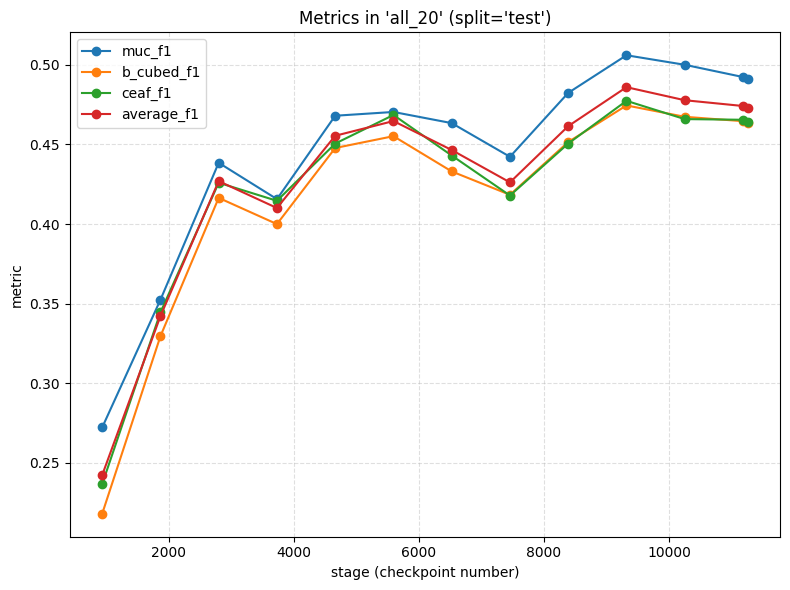

In [8]:


# Set these variables as appropriate for your environment
folder = 'all_20'  # or 'plots/all_20' if running from repo root
split = 'test'
pattern = 'scierc_coref'  # use 'scierc_joint_er' for the ER files

metric_to_plot = ['muc_f1', 'b_cubed_f1', 'ceaf_f1', 'average_f1'] 
out_path = f'{folder}_{pattern}_{split}.png'

_ = plot_metrics(folder=folder, split=split, metrics=metric_to_plot, pattern=pattern, out_path=out_path, show=True)

Saved plot to all_20_scierc_joint_test.png


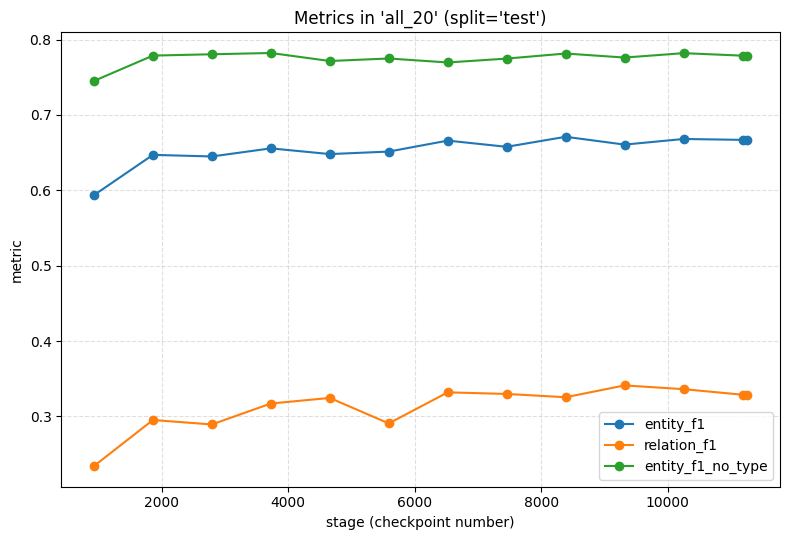

In [9]:
folder = 'all_20'  # or 'plots/all_20' if running from repo root
split = 'test'
pattern = 'scierc_joint'  # use 'scierc_joint_er' for the ER files

metric_to_plot = ['entity_f1', 'relation_f1', 'entity_f1_no_type'] 
out_path = f'{folder}_{pattern}_{split}.png'

_ = plot_metrics(folder=folder, split=split, metrics=metric_to_plot, pattern=pattern, out_path=out_path, show=True)

Saved plot to er_100_scierc_joint_test.png


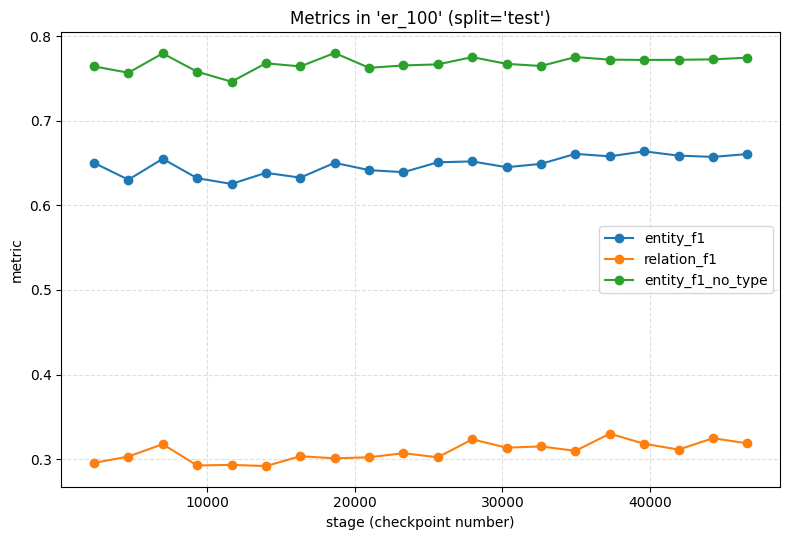

In [10]:
folder = 'er_100'  # or 'plots/all_20' if running from repo root
split = 'test'
pattern = 'scierc_joint'  # use 'scierc_joint_er' for the ER files

metric_to_plot = ['entity_f1', 'relation_f1', 'entity_f1_no_type'] 
out_path = f'{folder}_{pattern}_{split}.png'

_ = plot_metrics(folder=folder, split=split, metrics=metric_to_plot, pattern=pattern, out_path=out_path, show=True)

Saved plot to all_100_scierc_joint_test.png


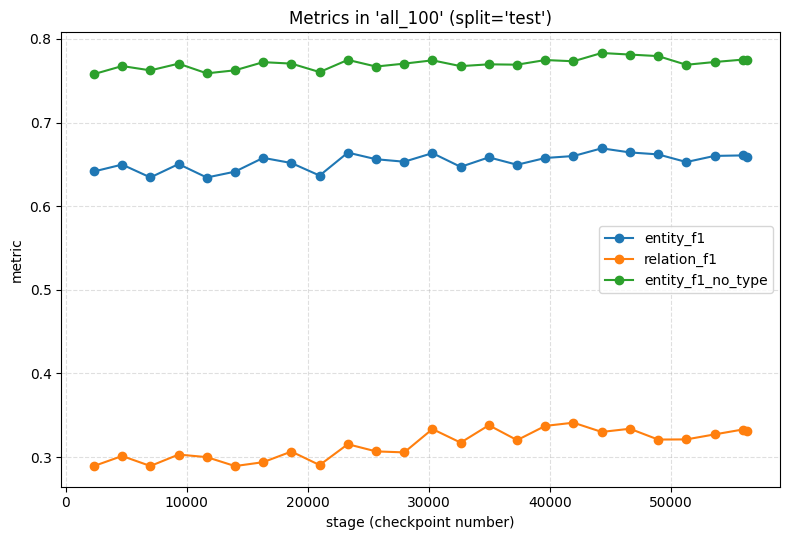

In [11]:
folder = 'all_100'  # or 'plots/all_20' if running from repo root
split = 'test'
pattern = 'scierc_joint'  # use 'scierc_joint_er' for the ER files

metric_to_plot = ['entity_f1', 'relation_f1', 'entity_f1_no_type'] 
out_path = f'{folder}_{pattern}_{split}.png'

_ = plot_metrics(folder=folder, split=split, metrics=metric_to_plot, pattern=pattern, out_path=out_path, show=True)

Saved plot to all_100_scierc_coref_test.png


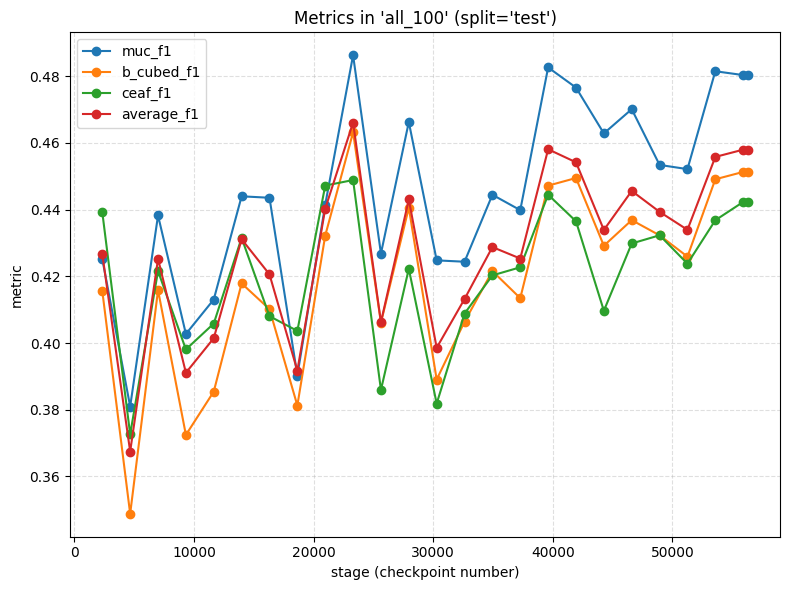

In [12]:
folder = 'all_100'  # or 'plots/all_20' if running from repo root
split = 'test'
pattern = 'scierc_coref'  # use 'scierc_joint_er' for the ER files

metric_to_plot = ['muc_f1', 'b_cubed_f1', 'ceaf_f1', 'average_f1'] 
out_path = f'{folder}_{pattern}_{split}.png'

_ = plot_metrics(folder=folder, split=split, metrics=metric_to_plot, pattern=pattern, out_path=out_path, show=True)